In [195]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
from dataclasses import *
import numpy as np
from typing import Dict 
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
import scipy.integrate as integrate
from EnforceTyping import *
from ParticlesandFields import *

In [196]:
@dataclass(kw_only= True)
class ElectroStaticField2D(ClassicalField):
  """
  A class used to represent a 2D Electrostatic Field

  Attributes
  ----------
  FieldSources: Dict
      a formatted string to print out what the animal says
  Dimensionality: tuple
      a tuple of the dimensionality of the field  

  Methods
  -------
  Dynamics(self, ObservationPosition: np.ndarray, Time: float)-> np.ndarray:
      Represents the value of the field at any given point(s) or time. 
  Potential(self, ObservationPosition: np.ndarray, Time: float)-> float:
      Represents the potential dure to the field at a given position and/or time  
  PotentialDifference(self, InitialPosition: np.ndarray, FinalPosition: np.ndarray, Time: float)-> float:
      Represents the potential difference between two positions at a given time in the vector field   
  Gradient(self, ObservationPosition: np.ndarray, Time: float)-> float:
      Represents the gradient at a given position and/or time in the vector field 
  Curl(self, ObservationPosition: np.ndarray, Time: float)-> float:
      Represents the curl at a given position and/or time in the vector field 
  Divergence(self, ObservationPosition: np.ndarray, Time: float)-> float:
      Represents the divergence at a given position and/or time in the vector field
  """
  FieldSources: Dict
  Dimensionality: tuple = (2, )
  def __call__(self, ObservationPosition: np.ndarray)->np.ndarray:
      return self.Dynamics(ObservationPosition)
  @EnforceMethodTyping
  def Dynamics(self, ObservationPosition: np.ndarray)->np.ndarray:
    """
    This function outputs the field strength due to Field Sources experienced at any given point(s) or time. 
    This determines the physics of the field(a 2D Electricstatic Field in this case)

    Args:
        ObservationPosition (np.ndarray): The position.

    Returns:
        np.ndarray: The electric field strength vector at the given position.
    """
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, ClassicalParticle),  "The FieldSource is not a Particle"
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    ElectricFieldVector = np.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= np.broadcast_to(SourcePosition, reversed(ObservationPosition.shape)).T
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = np.linalg.norm(DisplacementVector, axis=0)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**3
    ElectricFieldVector= CoulombConstant * ElectricFieldVector
    return np.round(ElectricFieldVector, 3) #N/C or V/m
  @EnforceMethodTyping
  def Potential(self, ObservationPosition: np.ndarray)-> float:
    """
    Calculate the Potential(Voltage) at a position in the field.

    Args:
        ObservationPosition (np.ndarray): The position.

    Returns:
        np.ndarray: The Electric Potental at the given position.
    """
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, ClassicalParticle),  "The FieldSource is not a Particle"

    CoulombConstant = 8.9875e9 #N*m^2/C^2
    ElectricPotential = 0.0

    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= np.broadcast_to(SourcePosition, reversed(ObservationPosition.shape)).T
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = np.linalg.norm(DisplacementVector, axis=0)
      ElectricPotential += FieldSource.Charge / DisplacementMagnitude

    ElectricPotential= CoulombConstant * ElectricPotential
    return np.round(ElectricPotential, 3) #V
  
  @EnforceMethodTyping
  def PotentialDifference(self, InitialPosition: np.ndarray, FinalPosition: np.ndarray)-> float:
    """
    Calculate the potental difference between the initial position and the final position in the field.

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    assert InitialPosition.shape == self.Dimensionality, "InitialPosition has the wrong dimensions"
    assert FinalPosition.shape == self.Dimensionality, "FinalPosition has the wrong dimensions"
    PorentialDifference= self.Potential(InitialPosition)- self.Potential(FinalPosition)
    return PorentialDifference

  def Gradient(self, ObservationPosition: np.ndarray, Delta: float= 0.001)->np.ndarray:
    """
    This function returns the derivative of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    Gradient= np.zeros_like(ObservationPosition)
    for i in range(len(ObservationPosition)):
      di= np.zeros_like(ObservationPosition)
      di[i, ] = di[i, ]+Delta
      plusdi= ObservationPosition+ di
      minusdi= ObservationPosition- di
      Gradient[i]= (self.Dynamics(plusdi)- self.Dynamics(minusdi))[i]/ (2* Delta)
    return Gradient
  
  def Curl(self, ObservationPosition: np.ndarray)-> float:
    """
    This function returns the Curl of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  
  def Divergence(self, ObservationPosition: np.ndarray)-> float:
    """
    This function returns the Divergence of the field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  @EnforceMethodTyping
  def PlotField(self, LowBound= -20, HighBound= 20):
    """
    This funtion plots the 2D electric vector field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    ObservationPosition= np.meshgrid(np.linspace(LowBound, HighBound, 25), 
                                    np.linspace(LowBound, HighBound, 25))
    ObservationPosition= np.stack(ObservationPosition)
    xd, yd = self.Dynamics(ObservationPosition)
    xd = xd / np.sqrt(xd**2 + yd**2)
    yd = yd / np.sqrt(xd**2 + yd**2)
    color_aara = np.sqrt(xd**2+ yd**2)
    fig, ax = plt.subplots(1,1)
    cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
    fig.colorbar(cp)
    plt.rcParams['figure.dpi'] = 150
    plt.show()

In [197]:

class HomogenousField(Field):
  
  def FieldStrength(self, ObservationPosition: np.ndarray)-> np.ndarray:
    return  np.zeros((ObservationPosition.shape[0], self.Dimensions), dtype=np.float64)
  def FieldPotential(self, ObservationPosition: np.ndarray)-> float:
    return  0.0

@dataclass(kw_only= True)
class LJField(Field):
    FieldSources: list[ClassicalParticle]
    FieldHighBound: float
    FieldLowBound: float
    def __call__(self, ObservationPosition: np.ndarray)->np.ndarray:
        return self.FieldStrength(ObservationPosition)
    @EnforceMethodTyping
    def FieldStrength(self, ObservationPosition: np.ndarray)->np.ndarray:
        'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
        CoulombConstant = 8.9875e9 #N*m^2/C^2
        for FieldSource in self.FieldSources:
            if type(FieldSource) != Particle:
                raise TypeError("The input is not valid")
        assert type(ObservationPosition) == np.ndarray, "Invalid Reference point data type"
        ElectricFieldVector = np.zeros_like(ObservationPosition)
        for FieldSource in self.FieldSources:
            PositionMatrices= np.stack([np.ones_like(ObservationPosition[0])* FieldSource.Position[0].item(), 
                                            np.ones_like(ObservationPosition[1])* FieldSource.Position[1].item()])
            DisplacementVector = ObservationPosition - PositionMatrices
            DisplacementMagnitude = np.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
            ElectricFieldVector += ((FieldSource.Charge) / DisplacementMagnitude**3 * DisplacementVector) - ((FieldSource.Charge) / DisplacementMagnitude**6 * DisplacementVector)
        ElectricFieldVector= CoulombConstant *ElectricFieldVector
        return ElectricFieldVector #N/C or V/m
    @EnforceMethodTyping
    def FieldPotential(self, InitialPosition: np.ndarray, FinalPosition: np.ndarray, resolution: int= 5000)-> float:
        '''This method determines the amount of work required to get one position to another in the field'''
        XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
        YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
        XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
        YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
        WorkDone = 0
        for i in range(resolution):
            PositionFieldStrength = self.ForceFieldStrength(np.array([XPositions[i], YPositions[i]]))
            WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
        return WorkDone
    @EnforceMethodTyping
    def PlotField(self):
        'This funtion plots the 2D electric vector field'
        ObservationPosition= np.meshgrid(np.linspace(self.FieldLowBound, self.FieldHighBound, 40), 
                                        np.linspace(self.FieldLowBound, self.FieldHighBound, 40))
        ObservationPosition= np.stack(ObservationPosition)
        xd, yd = self.ElectricFieldStrength(ObservationPosition)
        xd = xd / np.sqrt(xd**2 + yd**2)
        yd = yd / np.sqrt(xd**2 + yd**2)
        color_aara = np.sqrt(xd**2+ yd**2)
        fig, ax = plt.subplots(1,1)
        cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
        fig.colorbar(cp)
        plt.rcParams['figure.dpi'] = 250
        plt.show()


In [198]:
NegativeCharge= ClassicalParticle(Mass=1.0, Charge= -1e-9)
PositiveCharge= ClassicalParticle(Mass=1.0, Charge= 1e-9)
Sources = {"Particle": [NegativeCharge, PositiveCharge],
           "Position": [np.array([1.0, 1.0]), np.array([-1.0, 1.0])]} #Update to accomodate charge density- a function that returns the charge at any point in the field

In [199]:
TestElectricField= ElectroStaticField2D(FieldSources=Sources)


In [200]:
Position1= np.array([0., 0.])
Position2= np.array([0., 1.])
TestElectricField(Position1), TestElectricField.Potential(Position1), TestElectricField.PotentialDifference(Position1, Position2), TestElectricField.Gradient(Position1)

(array([6.355, 0.   ]), 0.0, 0.0, array([0., 0.]))

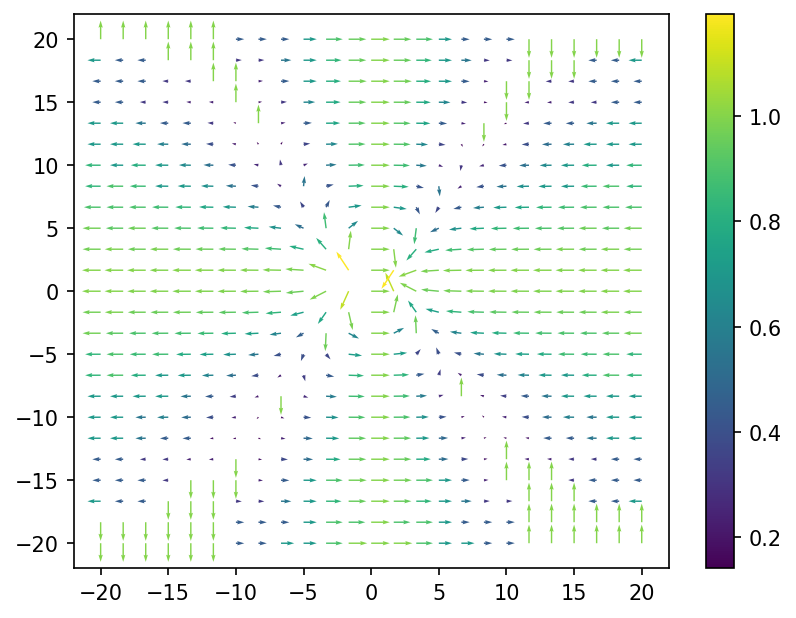

In [201]:
TestElectricField.PlotField()